In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from scipy import stats
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
from pytz import timezone
from collections import deque
import MySQLdb
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import Queue
est = timezone('US/Eastern')

Using TensorFlow backend.


In [32]:
btc = pd.read_csv('binance-data.csv')
twitter_sent = pd.read_csv('live_tweet.csv')
reddit_sent = pd.read_csv('live_reddit.csv')

btc.columns = ["Price","Volume", "Number_Trades", "Market_Cap","Supply", "Stamp"]
twitter_sent.columns = ["Sentiment", "Stamp"]
reddit_sent.columns = ["Sentiment", "Stamp"]

merged = pd.merge(twitter_sent, btc,  on='Stamp', how='inner').merge(reddit_sent, on='Stamp', how='inner')
data = merged[["Sentiment_x", "Sentiment_y","Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]].groupby(merged['Stamp']).mean()
datag = data[["Volume", "Market_Cap", "Supply", "Number_Trades", "Price"]]
tw_sentiment = data["Sentiment_x"]
rdt_sentiment = data["Sentiment_y"]

print "Dataset size: " + str(len(datag))
print "Timespan: " + str(len(datag)/60) + " hours"

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
values = datag.values.reshape(-1, datag.shape[1])
tw_sentiment = tw_sentiment.values.reshape(-1, 1)
rdt_sentiment = rdt_sentiment.values.reshape(-1, 1)
tw_sentiment = tw_sentiment.astype('float32')
rdt_sentiment = rdt_sentiment.astype('float32')
values = values.astype('float32')
scaled = scaler.fit_transform(values)

Dataset size: 11306
Timespan: 188 hours


7910
3388
Done


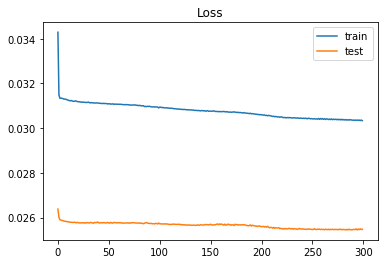

In [33]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
split = train_size

def create_dataset(dataset, look_back, tw_sentiment, rdt_sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):                
                current_tw_sentiment = tw_sentiment[i].tolist()[0]
                current_rdt_sentiment = rdt_sentiment[i].tolist()[0]
                a.append(current_tw_sentiment)
                a.append(current_rdt_sentiment)
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

look_back = 2
trainX, trainY = create_dataset(train, look_back, tw_sentiment[0:train_size], rdt_sentiment[0:train_size], sent=True)
testX, testY = create_dataset(test, look_back, tw_sentiment[train_size:len(scaled)], rdt_sentiment[train_size:len(scaled)], sent=True)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Creating new model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.save('models/LSTM_Philip_V4_{0}'.format(datetime.now()) + '.h5')

# Loading model
# model = load_model('models/LSTM_12-03-2018_GOOD.h5')

history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
yhat = model.predict(testX)
# yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
# testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
# rmse_sent = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print "Done"
# print 'Test RMSE: %.3f' % rmse_sent

pyplot.title("Loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
#Enter the values for you database connection
dsn_database = "ai_datasets_v4" # e.g. "MySQLdbtest"
dsn_hostname = "127.0.0.1"      # e.g.: "mydbinstance.xyz.us-east-1.rds.amazonaws.com"
dsn_port = 3306                 # e.g. 3306 
dsn_uid = "root"                # e.g. "user1"
dsn_pwd = ""                    # e.g. "Password123"


In [35]:
true_q = Queue.Queue()
pred_q = Queue.Queue()

def process_data(in_data):
    out_data = []
    for line in in_data:
        out_data.append(float(line.split(',')[0]))
    return np.array(out_data).reshape(-1,1)

def get_last_trade():
    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
    cursor = conn.cursor()
    cursor.execute ("select * from trades order by date desc limit 1")
    return cursor.fetchone()

    

In [37]:
diffs = deque([], maxlen=200)
lows = []
tops = []
top_lows = deque([], maxlen=30)
top_tops = deque([], maxlen=30)
bought = False
to_db = False
prev = 8590
in_cooldown = False
last_trade = ()
minute_ = 0
status = 0
current_decision = 0
recovery_time = 0

while True:
    
    # Processing data
    minute_ = minute_ + 1
    btc = open('binance-data.csv','r')
    tw_sent = open('live_tweet.csv','r')
    rdt_sent = open('live_reddit.csv','r')
    bit_data = btc.readlines()
    tw_sent_data = tw_sent.readlines()
    rdt_sent_data = rdt_sent.readlines()
    bit_data = process_data(bit_data[len(bit_data)-5:])
    tw_sent_data = process_data(tw_sent_data[len(tw_sent_data)-5:])
    rdt_sent_data = process_data(rdt_sent_data[len(rdt_sent_data)-5:])
    
    # Last price recieved
    real_price = bit_data[len(bit_data) - 1][0]
    
    # Scaling prices
    live = scaler.fit_transform(bit_data)
    
    # Creating datasets and making prediction
    testX, testY = create_dataset(live, 2, tw_sent_data, rdt_sent_data, sent=True)
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    yhat = model.predict(testX)
    
    #Re scaling prices
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    
    # Save real price and prediction price
    true_q.put(bit_data[4])
    pred_q.put(yhat_inverse[0])
    
    # Diference between real price and prediction
    alpha_diff = 100 * ((yhat_inverse[0][0] - float(real_price))/float(real_price))
    diffs.append(alpha_diff)
    diff_analisis = stats.describe(diffs)
    
    print "#######################################"
    print "In Cooldown ", in_cooldown
    print "#######################################"
    print "Minute: ", minute_
    print "#######################################"
    print "Diff analysis ", diff_analisis
    print "#######################################"
    print "########---> Initial values <---#######"
    print "#######################################"
    print "Pred: " + str(yhat_inverse[0][0])
    print "Real price: " + str(real_price)
    print "Diff: " + str(alpha_diff)

    if(len(diffs) >= 200):
        
        # Sorting all diffs
        sorted_diffs = sorted(diffs)
        # Taking the highest 75 (most negative)
        tops = sorted_diffs[0:75]
        # Taking the lowest 75 (most positive)
        lows = sorted_diffs[-75:]
        # Analyzing lists
        low_analisis = stats.describe(lows)
        top_analisis = stats.describe(tops)
        
        # Getting averages of tops and lows
        top_threshold = top_analisis.mean
        low_threshold = low_analisis.mean
        
        print "#######################################"
        print "######---> Averages (Phase 2) <---#####"
        print "#######################################"
        print "Average low: " + str(low_threshold)
        print "Average top: " + str(top_threshold)
        print "#######################################"
        print "#######################################"
        print "Top analysis", top_analisis
        print "#######################################"
        print "#######################################"
        print "Low analysis", low_analisis
        print "#######################################"
        print "#######################################"
        print "Low length", len(top_lows)
        print "Top length", len(top_tops)
        print "#######################################"
        print "#######################################"
        print "Low break: ", alpha_diff > low_threshold
        print "#######################################"
        print "Top break: ", alpha_diff < top_threshold 
        
        # If diff is greater than the average low
        if(alpha_diff > low_threshold):
            # Adding to top_lows list
            top_lows.append(alpha_diff)
            # Sorting
            sorted_lows = sorted(top_lows)
            top_lows = deque(sorted_lows, maxlen=30)
            
        # If diff is lower than the average high
        if(alpha_diff < top_threshold):
            # Adding to top_tops list
            top_tops.append(alpha_diff)            
            # Sorting 
            sorted_tops = sorted(top_tops)
            top_tops = deque(sorted_tops, maxlen=30)
             
        if(len(top_tops) >= 30 and len(top_lows) >= 30):
            # Analyzing top_tops and top_lows
            alpha_top_analisis = stats.describe(top_tops)
            alpha_low_analisis = stats.describe(top_lows)

            # Getting averages of top_tops and top_lows analisis
            alpha_top = alpha_top_analisis.mean
            alpha_low = alpha_low_analisis.mean

            print "####################################"
            print "####---> Signals (Phase 3) <---#####"
            print "Buy: " + str(alpha_top)
            print "####################################"
            print "Sell: " + str(alpha_low)

            if(not in_cooldown):
                
                if bought:
                    status = ((real_price - buy_price) / buy_price) * 100
                    print "####################################"
                    print "Current status"
                    print "####################################"
                    print "Status", status
                    print "####################################"
                    if status >= 0.15:
                        alpha_low = 0.10
                    
                # If difference is lower that than the lowest top (negative value) -> BUY
                if alpha_diff < alpha_top  and not bought:
                    
                    decision = 1
                    print "Buy at: " + str(real_price)
                    bought = True
                    to_db = True
                    in_cooldown = True
                    buy_price = real_price
                    
                # If difference is greater than the average low in the top_lows list -> SELL
                elif alpha_diff > alpha_low and bought:
                    if status < 0.15:
                        print "####################################"
                        print "Recovery time"
                        print "####################################"
                        print "Count", recovery_time
                        print "####################################"
                        if recovery_time >= 60:
                            decision = 2
                            print "Sell at: " + str(real_price)
                            bought = False
                            to_db = True
                            in_cooldown = True
                            buy_price = 0
                        else:
                            recovery_time = recovery_time + 1
                    else:
                        decision = 2
                        print "Sell at: " + str(real_price)
                        bought = False
                        to_db = True
                        in_cooldown = True
                        buy_price = 0
                        recovery_time = 0
                elif recovery_time > 1 and status >= 0.15 and bought:
                        decision = 2
                        print "Sell at: " + str(real_price)
                        bought = False
                        to_db = True
                        in_cooldown = True
                        buy_price = 0
                        recovery_time = 0
                else:
                    to_db = False
                    # Saving decision to DB
                if to_db == True:
                    conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
                    cursor=conn.cursor()
                    input_string = "INSERT INTO live_data (yhat, bit_data, sent_data, reddit_sent, date, decision) values ({},{},{},{},'{}',{});".format(
                        yhat_inverse[0][0],
                        bit_data[0][0],
                        tw_sent_data[4][0],
                        rdt_sent_data[4][0],
                        datetime.now(tz=est).strftime('%Y-%m-%d %H:%M:%S'),
                        decision)
                    cursor.execute(input_string)
                    current_decision = cursor.lastrowid
                    conn.commit()
                    cursor.close()
                    to_db = False
            else:
                last_trade = get_last_trade()
                if len(last_trade) is not 0 and current_decision == last_trade[3]:
                    in_cooldown = False
                print "####################################"
                print "In Cooldown"
                print "####################################"
                print "Last trade", last_trade
                print "####################################"
                print "Current decision", current_decision
                print "####################################"
    time.sleep(60)

1
#######################################
In Cooldown  False
#######################################
Minute:  1
#######################################
Diff analysis  DescribeResult(nobs=1, minmax=(0.061231264551804422, 0.061231264551804422), mean=0.061231264551804422, variance=nan, skewness=0.0, kurtosis=-3.0)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8595.26
Real price: 8590.0
Diff: 0.0612312645518
1
#######################################
In Cooldown  False
#######################################
Minute:  2
#######################################
Diff analysis  DescribeResult(nobs=2, minmax=(0.061231264551804422, 0.10779152237495838), mean=0.084511393463381407, variance=0.0010839288042792847, skewness=-4.0280551806201094e-16, kurtosis=-1.9999999999999996)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8594.29
Real price: 8

1
#######################################
In Cooldown  False
#######################################
Minute:  17
#######################################
Diff analysis  DescribeResult(nobs=17, minmax=(-0.25994745044061296, 0.11078344758423062), mean=-0.058137331756307122, variance=0.015160061230209354, skewness=0.05417003439705764, kurtosis=-1.360462056570071)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8609.2
Real price: 8605.37
Diff: 0.0445093623226
1
#######################################
In Cooldown  False
#######################################
Minute:  18
#######################################
Diff analysis  DescribeResult(nobs=18, minmax=(-0.25994745044061296, 0.11078344758423062), mean=-0.054129460505369688, variance=0.014557427497903612, skewness=-0.03555562137957319, kurtosis=-1.3264821331629182)
#######################################
########---> Initial values <---#######
###################

1
#######################################
In Cooldown  False
#######################################
Minute:  33
#######################################
Diff analysis  DescribeResult(nobs=33, minmax=(-0.25994745044061296, 0.11078344758423062), mean=-0.042143675956552711, variance=0.012769118907844121, skewness=-0.3386394094444922, kurtosis=-1.1004530084172173)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8596.67
Real price: 8590.03
Diff: 0.0773093742106
1
#######################################
In Cooldown  False
#######################################
Minute:  34
#######################################
Diff analysis  DescribeResult(nobs=34, minmax=(-0.25994745044061296, 0.11078344758423062), mean=-0.040560088824741485, variance=0.012467439349574018, skewness=-0.37995354137887305, kurtosis=-1.0472448542110484)
#######################################
########---> Initial values <---#######
#################

1
#######################################
In Cooldown  False
#######################################
Minute:  49
#######################################
Diff analysis  DescribeResult(nobs=49, minmax=(-0.25994745044061296, 0.38668356267547965), mean=-0.027052077810573033, variance=0.015060622669162122, skewness=0.44174251537835885, kurtosis=0.9790985563212291)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8539.19
Real price: 8529.99
Diff: 0.107802551644
1
#######################################
In Cooldown  False
#######################################
Minute:  50
#######################################
Diff analysis  DescribeResult(nobs=50, minmax=(-0.25994745044061296, 0.38668356267547965), mean=-0.028761987219477283, variance=0.014899452532185654, skewness=0.47504692821875516, kurtosis=1.011717559046045)
#######################################
########---> Initial values <---#######
######################

1
#######################################
In Cooldown  False
#######################################
Minute:  65
#######################################
Diff analysis  DescribeResult(nobs=65, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.065670968612589725, variance=0.02062933419320849, skewness=0.04275043400700247, kurtosis=0.30245515785137833)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8581.38
Real price: 8596.94
Diff: -0.180995996104
1
#######################################
In Cooldown  False
#######################################
Minute:  66
#######################################
Diff analysis  DescribeResult(nobs=66, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.066460391699867921, variance=0.020353090282513326, skewness=0.058920069392304986, kurtosis=0.3411284643270167)
#######################################
########---> Initial values <---#######
#####################

1
#######################################
In Cooldown  False
#######################################
Minute:  81
#######################################
Diff analysis  DescribeResult(nobs=81, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.065374866013744051, variance=0.017995354506113597, skewness=0.0669917278900428, kurtosis=0.5269662269808948)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8596.26
Real price: 8596.04
Diff: 0.0025793126835
1
#######################################
In Cooldown  False
#######################################
Minute:  82
#######################################
Diff analysis  DescribeResult(nobs=82, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.065376074216582189, variance=0.017773189755367583, skewness=0.06743134326732758, kurtosis=0.5705114307944879)
#######################################
########---> Initial values <---#######
#######################

1
#######################################
In Cooldown  False
#######################################
Minute:  97
#######################################
Diff analysis  DescribeResult(nobs=97, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.063754659939738986, variance=0.016280279439202992, skewness=0.1019221179810595, kurtosis=0.7348823729522227)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8590.24
Real price: 8598.96
Diff: -0.101450313468
1
#######################################
In Cooldown  False
#######################################
Minute:  98
#######################################
Diff analysis  DescribeResult(nobs=98, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.063005288769599654, variance=0.016167474107602404, skewness=0.086148257995128, kurtosis=0.7466486667174332)
#######################################
########---> Initial values <---#######
#########################

1
#######################################
In Cooldown  False
#######################################
Minute:  113
#######################################
Diff analysis  DescribeResult(nobs=113, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.064166696359164777, variance=0.015296969246608245, skewness=0.12987880342114294, kurtosis=0.715922837207227)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8601.88
Real price: 8610.5
Diff: -0.100066325271
1
#######################################
In Cooldown  False
#######################################
Minute:  114
#######################################
Diff analysis  DescribeResult(nobs=114, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.065590954744422308, variance=0.015392848199415542, skewness=0.1421939582057002, kurtosis=0.6689621929997562)
#######################################
########---> Initial values <---#######
#####################

1
#######################################
In Cooldown  False
#######################################
Minute:  129
#######################################
Diff analysis  DescribeResult(nobs=129, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.064847836381354981, variance=0.015252644560408143, skewness=0.1268603567570106, kurtosis=0.49053488654039823)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8617.29
Real price: 8619.99
Diff: -0.0313447470647
1
#######################################
In Cooldown  False
#######################################
Minute:  130
#######################################
Diff analysis  DescribeResult(nobs=130, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.065568156448098339, variance=0.015201858935488205, skewness=0.14068991705148132, kurtosis=0.4921401731560904)
#######################################
########---> Initial values <---#######
#################

1
#######################################
In Cooldown  False
#######################################
Minute:  145
#######################################
Diff analysis  DescribeResult(nobs=145, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.064192193713177609, variance=0.016212213087743659, skewness=0.14231698917756944, kurtosis=0.16737029189281216)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8598.01
Real price: 8605.0
Diff: -0.0812799607786
1
#######################################
In Cooldown  False
#######################################
Minute:  146
#######################################
Diff analysis  DescribeResult(nobs=146, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.064099125324973957, variance=0.01610166933345418, skewness=0.14059066237579665, kurtosis=0.188297070116358)
#######################################
########---> Initial values <---#######
###################

1
#######################################
In Cooldown  False
#######################################
Minute:  161
#######################################
Diff analysis  DescribeResult(nobs=161, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.064371926470682989, variance=0.01558387458043003, skewness=0.14021139156240386, kurtosis=0.17448339029081694)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8608.64
Real price: 8619.07
Diff: -0.120969493373
1
#######################################
In Cooldown  False
#######################################
Minute:  162
#######################################
Diff analysis  DescribeResult(nobs=162, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.064711476200396092, variance=0.015505757959447284, skewness=0.14806088769824632, kurtosis=0.1883231399651346)
#######################################
########---> Initial values <---#######
##################

1
#######################################
In Cooldown  False
#######################################
Minute:  177
#######################################
Diff analysis  DescribeResult(nobs=177, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.06029719958241217, variance=0.014960072373979783, skewness=0.08617133220505377, kurtosis=0.19064166993287834)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8593.07
Real price: 8596.33
Diff: -0.0379195249601
1
#######################################
In Cooldown  False
#######################################
Minute:  178
#######################################
Diff analysis  DescribeResult(nobs=178, minmax=(-0.3934272075440497, 0.38668356267547965), mean=-0.060315801841278327, variance=0.014875613786914156, skewness=0.08687261334972186, kurtosis=0.20869433333135268)
#######################################
########---> Initial values <---#######
################

1
#######################################
In Cooldown  False
#######################################
Minute:  193
#######################################
Diff analysis  DescribeResult(nobs=193, minmax=(-0.3934272075440497, 0.83729579743094318), mean=-0.043969221406076037, variance=0.024096786807333497, skewness=1.6321727451802372, kurtosis=6.685389677259069)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.31
Real price: 8428.36
Diff: 0.0112431978167
1
#######################################
In Cooldown  False
#######################################
Minute:  194
#######################################
Diff analysis  DescribeResult(nobs=194, minmax=(-0.3934272075440497, 0.83729579743094318), mean=-0.042858407825242861, variance=0.024211310911083424, skewness=1.6045142327660644, kurtosis=6.516930265918971)
#######################################
########---> Initial values <---#######
######################

1
#######################################
In Cooldown  False
#######################################
Minute:  203
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3934272075440497, 0.83729579743094318), mean=-0.045457024874989378, variance=0.023716717860139971, skewness=1.6557224218185747, kurtosis=6.754732412901214)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8415.14
Real price: 8418.0
Diff: -0.0339441895343
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0989311290536
Average top: -0.179172806551
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.3934272075440497, -0.10592332526819029), mean=-0.17917280655070447, variance=0.0039508879841559557, skewness=-1.2547482151239986, kurtosis=1.4048529930443179

1
#######################################
In Cooldown  False
#######################################
Minute:  209
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.3934272075440497, 0.83729579743094318), mean=-0.039983040314290022, variance=0.023832928561779394, skewness=1.5877986323501474, kurtosis=6.452186036539933)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.66
Real price: 8397.23
Diff: 0.159900664416
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104680260673
Average top: -0.174938629469
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.3934272075440497, -0.10145031346813019), mean=-0.17493862946919553, variance=0.0041705128811416496, skewness=-1.2237352948956077, kurtosis=1.3486701474137863)


1
#######################################
In Cooldown  False
#######################################
Minute:  215
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.046725390677226288, variance=0.026259509048116247, skewness=1.1770111809663568, kurtosis=5.9461078387673645)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8411.41
Real price: 8440.0
Diff: -0.338707512589
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.101442656844
Average top: -0.187269661975
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10145031346813019), mean=-0.18726966197532002, variance=0.0077711470653910788, skewness=-2.1012360114364603, kurtosis=5.704412733830717

1
#######################################
In Cooldown  False
#######################################
Minute:  221
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.0461186377073739, variance=0.026535187419303677, skewness=1.154841949650243, kurtosis=5.752870157071703)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8419.93
Real price: 8430.02
Diff: -0.119695000724
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104264227384
Average top: -0.187943387578
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.1034220036418689), mean=-0.18794338757811965, variance=0.0076728735387782913, skewness=-2.134490049579544, kurtosis=5.844269263448629)
###

1
#######################################
In Cooldown  False
#######################################
Minute:  227
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.04441231473104125, variance=0.026366029881883957, skewness=1.138347634363156, kurtosis=5.810358015727603)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.13
Real price: 8424.21
Diff: -0.250232570027
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104584086353
Average top: -0.185887275865
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10237076781362422), mean=-0.18588727586479223, variance=0.0078599998303816934, skewness=-2.1071443137093646, kurtosis=5.64569641480597)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  233
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.052674790919520424, variance=0.027511104208612226, skewness=1.127283467139355, kurtosis=5.445057353115047)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8435.2
Real price: 8446.5
Diff: -0.133804034955
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.100762788781
Average top: -0.196803905574
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10730437136793557), mean=-0.19680390557426075, variance=0.0082005294176990626, skewness=-1.8406065387860155, kurtosis=4.240531353936905)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  239
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.058387643282962108, variance=0.026642315160928083, skewness=1.1759496548462993, kurtosis=5.89951067219476)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8458.0
Real price: 8471.63
Diff: -0.16094757222
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0930668853844
Average top: -0.19984612781
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.11143781421155978), mean=-0.19984612781039834, variance=0.007880739847730996, skewness=-1.8951146184777283, kurtosis=4.524292896924535)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  245
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.057922598105854754, variance=0.02661126500002154, skewness=1.1698462441266655, kurtosis=5.907164994477787)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.27
Real price: 8470.26
Diff: -0.188783682555
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0929407240863
Average top: -0.199365450374
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.11104571393386652), mean=-0.19936545037408215, variance=0.0079599012874630205, skewness=-1.8711679630214344, kurtosis=4.428666307234118

1
#######################################
In Cooldown  False
#######################################
Minute:  251
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.058966179736622326, variance=0.026535979004275987, skewness=1.1875949610156649, kurtosis=5.986131079689622)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.43
Real price: 8462.02
Diff: -0.0896985885167
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0914277060102
Average top: -0.199667910487
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.11104571393386652), mean=-0.19966791048657911, variance=0.0079693693643817318, skewness=-1.8588932685487873, kurtosis=4.3850451574639

1
#######################################
In Cooldown  False
#######################################
Minute:  257
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.058969164870021587, variance=0.026544823495923013, skewness=1.1963703032558073, kurtosis=5.969862765805878)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8475.73
Real price: 8470.01
Diff: 0.0675840406328
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0918136485069
Average top: -0.199623946256
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.11104571393386652), mean=-0.19962394625553695, variance=0.0078546442644757877, skewness=-1.8755266014691465, kurtosis=4.55023774450517

1
#######################################
In Cooldown  False
#######################################
Minute:  263
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.054758148126170816, variance=0.025336847542753112, skewness=1.2868739469045944, kurtosis=6.553690611898082)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8475.58
Real price: 8485.01
Diff: -0.111147758665
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0918163757798
Average top: -0.189929927869
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10935689186378224), mean=-0.18992992786939447, variance=0.0073690627087581242, skewness=-2.164374781266685, kurtosis=6.145301298564819

1
#######################################
In Cooldown  False
#######################################
Minute:  269
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.05389283898688358, variance=0.025386654969404624, skewness=1.2530993018061065, kurtosis=6.514513586249059)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8485.76
Real price: 8490.0
Diff: -0.0499783752945
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0921155433429
Average top: -0.189340070034
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10746159572922719), mean=-0.18934007003403222, variance=0.0077372977687293837, skewness=-2.0551586998062232, kurtosis=5.446953029849388

1
#######################################
In Cooldown  False
#######################################
Minute:  275
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.04780338213143074, variance=0.025644573691410166, skewness=1.1492810565756675, kurtosis=6.168543932678499)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.25
Real price: 8455.0
Diff: 0.0738861065937
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0987964529511
Average top: -0.186488145606
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10319083627005216), mean=-0.18648814560642785, variance=0.008086304992578848, skewness=-1.970995119945813, kurtosis=5.02830943558369)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  281
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.051123066646770313, variance=0.025851098808780393, skewness=1.1925427796553822, kurtosis=6.125730557849048)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8462.46
Real price: 8476.99
Diff: -0.171417161339
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0976491616918
Average top: -0.189244210403
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10647532505910165), mean=-0.18924421040308284, variance=0.0077672879820624239, skewness=-2.0408844372919512, kurtosis=5.39744929379242

1
#######################################
In Cooldown  False
#######################################
Minute:  287
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.049935757550009445, variance=0.02592528975453904, skewness=1.166463452601086, kurtosis=6.0375112094753725)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.35
Real price: 8438.27
Diff: 0.0839566900265
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0996301958037
Average top: -0.189244210403
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10647532505910165), mean=-0.18924421040308284, variance=0.0077672879820624239, skewness=-2.0408844372919512, kurtosis=5.397449293792428

1
#######################################
In Cooldown  False
#######################################
Minute:  293
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.047883413693805596, variance=0.026536468901400156, skewness=1.106673330103255, kurtosis=5.619557545009918)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8425.27
Real price: 8446.84
Diff: -0.25539044039
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104446682038
Average top: -0.190726650912
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10647532505910165), mean=-0.19072665091208429, variance=0.0077743175733486422, skewness=-1.999713546864827, kurtosis=5.242874178712443)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  299
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.047504808686995588, variance=0.026414871616442334, skewness=1.1089650580500041, kurtosis=5.685997284666643)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.11
Real price: 8438.0
Diff: -0.0223482126985
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.103757370785
Average top: -0.189740229175
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10450321047760455), mean=-0.18974022917510139, variance=0.0078717722041068416, skewness=-1.983822193148819, kurtosis=5.140318267115395)

1
#######################################
In Cooldown  False
#######################################
Minute:  305
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.046612251594395311, variance=0.026422743371179086, skewness=1.094962178177225, kurtosis=5.6598737032831465)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8421.4
Real price: 8420.19
Diff: 0.0144096547999
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.103908806365
Average top: -0.189404824646
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10419709332019061), mean=-0.18940482464619179, variance=0.007921265514225154, skewness=-1.9688102578608417, kurtosis=5.077489163900292)


1
#######################################
In Cooldown  False
#######################################
Minute:  311
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.03887613766933054, variance=0.027693082704166611, skewness=1.0125060561022325, kurtosis=4.946706427035164)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8379.14
Real price: 8382.0
Diff: -0.0341715320031
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.115030024977
Average top: -0.185997634625
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10004206445683111), mean=-0.18599763462545302, variance=0.0082932439304176219, skewness=-1.9010041391925472, kurtosis=4.698180046905708)

1
#######################################
In Cooldown  False
#######################################
Minute:  317
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.036732784002990036, variance=0.027301781019688727, skewness=1.0116491654185102, kurtosis=5.103032523420355)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8380.46
Real price: 8398.46
Diff: -0.214337100195
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.115030024977
Average top: -0.182342331075
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.09100202447980732), mean=-0.18234233107486822, variance=0.0084536510364826897, skewness=-1.9328238156744824, kurtosis=4.734868722955085

1
#######################################
In Cooldown  False
#######################################
Minute:  323
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.042772371462745859, variance=0.027622253424825407, skewness=1.0625634571809126, kurtosis=5.08822965615499)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8409.26
Real price: 8405.0
Diff: 0.0507394222189
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.11065995383
Average top: -0.188427516984
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10319083627005216), mean=-0.18842751698354968, variance=0.0082032560943599651, skewness=-1.8840555905387768, kurtosis=4.645940096712095)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  329
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.041740122428552878, variance=0.027387386123876808, skewness=1.0670074548827913, kurtosis=5.1907768185538306)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8416.15
Real price: 8420.06
Diff: -0.0463856923229
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.11065995383
Average top: -0.185750828647
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10237076781362422), mean=-0.18575082864668077, variance=0.0083609337771251863, skewness=-1.9007695670728297, kurtosis=4.59479477306834

1
#######################################
In Cooldown  False
#######################################
Minute:  335
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.039736216854433029, variance=0.026465813826357328, skewness=1.1194803586316457, kurtosis=5.652080061283568)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.71
Real price: 8417.99
Diff: 0.0679144457287
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.108534232274
Average top: -0.178939384808
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.097262385891270176), mean=-0.17893938480831548, variance=0.0083646051564060294, skewness=-2.0597653117818715, kurtosis=5.16857473193456

1
#######################################
In Cooldown  False
#######################################
Minute:  341
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.041304889614983561, variance=0.02619738314448735, skewness=1.145211937215221, kurtosis=5.847435936297634)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.32
Real price: 8410.01
Diff: 0.00370141132412
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.105286353018
Average top: -0.179762281778
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10004206445683111), mean=-0.17976228177799694, variance=0.0082791520693900698, skewness=-2.0741188202060696, kurtosis=5.253173079305338)

1
#######################################
In Cooldown  False
#######################################
Minute:  347
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.038598781372109189, variance=0.025933035908505587, skewness=1.120430530446971, kurtosis=5.941938045795913)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8407.75
Real price: 8404.03
Diff: 0.0442528577064
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.105653987471
Average top: -0.176789217873
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096220391793445076), mean=-0.17678921787303034, variance=0.0085118850999903965, skewness=-2.0582921874882616, kurtosis=5.094846430239581

1
#######################################
In Cooldown  False
#######################################
Minute:  353
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.039995735012525326, variance=0.026066306008209559, skewness=1.1354927804421613, kurtosis=5.895625718360698)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8413.0
Real price: 8402.13
Diff: 0.129348711279
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.105455551335
Average top: -0.17810914629
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.097243904252155816), mean=-0.17810914628991048, variance=0.0084065925773888321, skewness=-2.063722900268906, kurtosis=5.169464925920186)
#

1
#######################################
In Cooldown  False
#######################################
Minute:  359
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.036046924334764169, variance=0.026075952129395501, skewness=1.0929634710694036, kurtosis=5.784017103204288)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8396.92
Real price: 8404.0
Diff: -0.0841884258984
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.109396232665
Average top: -0.175061500979
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.08969858851669503), mean=-0.17506150097948972, variance=0.0085045086011400622, skewness=-2.0964170851501174, kurtosis=5.268084805388039

1
#######################################
In Cooldown  False
#######################################
Minute:  365
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.038150606390866787, variance=0.026387242491251892, skewness=1.0980440430836886, kurtosis=5.64923264658146)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.54
Real price: 8420.0
Diff: -0.195463275683
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.108952694387
Average top: -0.178653167491
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.08969858851669503), mean=-0.1786531674907138, variance=0.0083376395855058461, skewness=-2.059823228913226, kurtosis=5.255643376111642)
##

1
#######################################
In Cooldown  False
#######################################
Minute:  371
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.040471815290085311, variance=0.026192111565477922, skewness=1.1442542928163457, kurtosis=5.834528270501732)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.41
Real price: 8417.74
Diff: -0.0632935992915
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.105810977601
Average top: -0.178965036785
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.096220391793445076), mean=-0.17896503678518258, variance=0.0082887000769620717, skewness=-2.0753559878682712, kurtosis=5.3159215060782

1
#######################################
In Cooldown  False
#######################################
Minute:  377
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.83729579743094318), mean=-0.043510213489890572, variance=0.026784668256065364, skewness=1.1199751441076926, kurtosis=5.602716918589136)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8428.62
Real price: 8441.0
Diff: -0.146628990937
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.104660133894
Average top: -0.184237222087
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.097262385891270176), mean=-0.18423722208679222, variance=0.0084698067104861472, skewness=-1.9519084138401046, kurtosis=4.649513846710538

1
#######################################
In Cooldown  False
#######################################
Minute:  383
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.51011795512050528), mean=-0.049825125704471424, variance=0.021200428799479559, skewness=0.19758564751020086, kurtosis=2.101204240126185)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8428.75
Real price: 8420.99
Diff: 0.092104298307
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0889225929996
Average top: -0.184890727309
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10004206445683111), mean=-0.18489072730852577, variance=0.0083848079669752943, skewness=-1.970943222350354, kurtosis=4.737613536315699

1
#######################################
In Cooldown  False
#######################################
Minute:  389
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.33821837323342463), mean=-0.056005313055377995, variance=0.018194748095010989, skewness=-0.25780113769192775, kurtosis=1.2574317631294667)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8413.58
Real price: 8419.93
Diff: -0.0754617689815
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0751255816242
Average top: -0.185407682464
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10319083627005216), mean=-0.1854076824640962, variance=0.0081841207767451574, skewness=-2.0404299012153806, kurtosis=5.05333595965

1
#######################################
In Cooldown  False
#######################################
Minute:  395
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.33821837323342463), mean=-0.05935518365693649, variance=0.017649828453196195, skewness=-0.2539550405062234, kurtosis=1.3881660691686077)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8428.9
Real price: 8430.04
Diff: -0.0135531867287
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0697174720697
Average top: -0.185585654974
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10419709332019061), mean=-0.18558565497384763, variance=0.0081559998196927327, skewness=-2.049530316185251, kurtosis=5.08746563388210

1
#######################################
In Cooldown  False
#######################################
Minute:  401
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.33821837323342463), mean=-0.056363907872452386, variance=0.017730397235276939, skewness=-0.29552434240722175, kurtosis=1.3835476656791972)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8418.62
Real price: 8417.97
Diff: 0.00771136776445
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0729275802703
Average top: -0.183509061953
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.10319083627005216), mean=-0.18350906195308631, variance=0.0083210278678216339, skewness=-2.0379877974661817, kurtosis=4.9714289522

1
#######################################
In Cooldown  False
#######################################
Minute:  407
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.33821837323342463), mean=-0.055149457384481522, variance=0.01782441891636153, skewness=-0.3175349216404222, kurtosis=1.351420699747421)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8412.56
Real price: 8412.3
Diff: 0.00314364828882
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0740348889846
Average top: -0.18380285765
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.1027521715349167), mean=-0.183802857649943, variance=0.0082861433961412267, skewness=-2.0452296885608607, kurtosis=5.0084485041972275)


1
#######################################
In Cooldown  False
#######################################
Minute:  413
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.59227230776143125, 0.33821837323342463), mean=-0.054555973210208074, variance=0.016659059957854754, skewness=-0.2595131028653588, kurtosis=1.3502190305453805)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8404.16
Real price: 8406.0
Diff: -0.0219221203605
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0709452937182
Average top: -0.18031468891
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.59227230776143125, -0.1027521715349167), mean=-0.18031468890959132, variance=0.0071742532249383182, skewness=-2.137968051648911, kurtosis=6.239223325096647

1
#######################################
In Cooldown  False
#######################################
Minute:  419
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36816137431730317, 0.33821837323342463), mean=-0.050783157865795327, variance=0.014724192716466198, skewness=0.0875373600252966, kurtosis=0.43630467478805457)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8407.52
Real price: 8404.99
Diff: 0.030083970207
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0702033312932
Average top: -0.170629026778
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36816137431730317, -0.10149158682368295), mean=-0.1706290267777, variance=0.0046061982492497577, skewness=-1.3360581706566614, kurtosis=1.1007868701913948)

1
#######################################
In Cooldown  False
#######################################
Minute:  425
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.36816137431730317, 0.33821837323342463), mean=-0.050949349558353577, variance=0.014590223302869292, skewness=0.08513938412626397, kurtosis=0.4907233502881039)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.1
Real price: 8404.0
Diff: -0.0107254543967
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0684426982941
Average top: -0.170366987627
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.36816137431730317, -0.10004206445683111), mean=-0.17036698762747629, variance=0.0046384022276401661, skewness=-1.3243328863887696, kurtosis=1.0759899584988

1
#######################################
In Cooldown  False
#######################################
Minute:  431
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.05268564323650448, variance=0.016629576968908572, skewness=-0.5459155835616608, kurtosis=2.7913882419967493)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8439.46
Real price: 8446.31
Diff: -0.0811240907272
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0684426982941
Average top: -0.1757221355
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.096220391793445076), mean=-0.17572213550013843, variance=0.0088491189341267408, skewness=-2.7817804795168177, kurtosis=9.7822062488234

1
#######################################
In Cooldown  False
#######################################
Minute:  437
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.052133612039838934, variance=0.016687777492884043, skewness=-0.5676699029139249, kurtosis=2.7945100629627344)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8443.1
Real price: 8460.02
Diff: -0.199981057964
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0684624795302
Average top: -0.17573888085
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.089263461939054878), mean=-0.17573888084995484, variance=0.0090119799439748616, skewness=-2.717483949921494, kurtosis=9.39185804118013

1
#######################################
In Cooldown  False
#######################################
Minute:  443
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.052886267801615983, variance=0.016602624197693639, skewness=-0.5666614719361516, kurtosis=2.831460304051915)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8465.53
Real price: 8460.0
Diff: 0.0653696623818
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0669310956575
Average top: -0.176155606871
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.089263461939054878), mean=-0.17615560687051429, variance=0.0090016742422905187, skewness=-2.708602060075745, kurtosis=9.37345630327998

1
#######################################
In Cooldown  False
#######################################
Minute:  449
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.050261857215971588, variance=0.016412629034982373, skewness=-0.6148761730804556, kurtosis=2.9925008679148615)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8452.06
Real price: 8445.0
Diff: 0.083548419923
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0677638742239
Average top: -0.172812893233
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.085211595259231512), mean=-0.17281289323304266, variance=0.009168070121237909, skewness=-2.714644045602823, kurtosis=9.323123026874155

1
#######################################
In Cooldown  False
#######################################
Minute:  455
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.04669873126415381, variance=0.015640827930253506, skewness=-0.6180434587111647, kurtosis=3.371631322218839)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8451.87
Real price: 8465.98
Diff: -0.166711816736
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0686729923456
Average top: -0.166216506965
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.082650211442204538), mean=-0.16621650696513618, variance=0.0085535159967795316, skewness=-3.0435987114802465, kurtosis=11.702870158002

1
#######################################
In Cooldown  False
#######################################
Minute:  461
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.04769450749599298, variance=0.01580143712324444, skewness=-0.5930025271653261, kurtosis=3.243151155070869)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8444.3
Real price: 8449.86
Diff: -0.0658022181729
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0687000810828
Average top: -0.168254676557
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.084188425898381727), mean=-0.16825467655671963, variance=0.0084405520981567419, skewness=-3.050470660621146, kurtosis=11.81338087125388

1
#######################################
In Cooldown  False
#######################################
Minute:  467
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.044673038569321408, variance=0.015288914297927125, skewness=-0.6338123774278406, kurtosis=3.591857242116088)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.23
Real price: 8452.99
Diff: -0.0681360234663
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0686532299784
Average top: -0.162552617057
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.076216912077425647), mean=-0.16255261705700719, variance=0.0084736142697479297, skewness=-3.100745251044352, kurtosis=12.38498240205

1
#######################################
In Cooldown  False
#######################################
Minute:  473
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.045774739586356417, variance=0.015198698707407962, skewness=-0.6275775233776666, kurtosis=3.6150229804390674)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8429.25
Real price: 8437.0
Diff: -0.0918457204871
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0678223305483
Average top: -0.162819770786
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079137029752750498), mean=-0.16281977078637674, variance=0.0084305442974584258, skewness=-3.1224299031880807, kurtosis=12.4981448814

1
#######################################
In Cooldown  False
#######################################
Minute:  479
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.047396035921623975, variance=0.014958662860660306, skewness=-0.6196603322983432, kurtosis=3.7709254425663348)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8430.8
Real price: 8442.72
Diff: -0.141177473018
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0647632605579
Average top: -0.162852671529
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.081124090727187279), mean=-0.1628526715294111, variance=0.0083871198830041595, skewness=-3.1526993569854014, kurtosis=12.646912950640

1
#######################################
In Cooldown  False
#######################################
Minute:  485
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.04495724397255163, variance=0.015067099754340068, skewness=-0.6410302999876984, kurtosis=3.756328747371467)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8421.12
Real price: 8420.02
Diff: 0.0130770918596
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0673571823687
Average top: -0.160775180022
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079137029752750498), mean=-0.1607751800216205, variance=0.008563348768729391, skewness=-3.1041334934483205, kurtosis=12.30484017978023

1
#######################################
In Cooldown  False
#######################################
Minute:  490
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.050867418357631901, variance=0.01466120110686441, skewness=-0.6352747449697692, kurtosis=3.8736700806632802)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8431.62
Real price: 8430.06
Diff: 0.0185181807721
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0598568691321
Average top: -0.165778409267
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.082650211442204538), mean=-0.16577840926700599, variance=0.0082438787354721915, skewness=-3.1583181741151143, kurtosis=12.76264966862

1
#######################################
In Cooldown  False
#######################################
Minute:  495
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.049572027672753906, variance=0.015525560464497304, skewness=-0.7619787585505788, kurtosis=3.801097036750228)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8424.96
Real price: 8464.79
Diff: -0.470549365371
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0625593446787
Average top: -0.167612106924
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.081124090727187279), mean=-0.16761210692427853, variance=0.0095157162947700855, skewness=-2.8806923814868064, kurtosis=9.918557765315

/home/thriven/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:202: Warning:

Data truncated for column 'date' at row 1



1
#######################################
In Cooldown  True
#######################################
Minute:  496
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.05088172064459897, variance=0.01574334462359233, skewness=-0.7402203945206111, kurtosis=3.625505459716301)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8427.69
Real price: 8449.99
Diff: -0.263923666626
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0625458006129
Average top: -0.170049434603
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.082238058813790607), mean=-0.17004943460292454, variance=0.0095339622018027655, skewness=-2.819531527485754, kurtosis=9.586483904363478)

1
#######################################
In Cooldown  False
#######################################
Minute:  501
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.053042384386492891, variance=0.015648735711769151, skewness=-0.7217829231639903, kurtosis=3.6316469567122622)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.3
Real price: 8450.11
Diff: -0.0569593176894
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0604900200486
Average top: -0.171827079066
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.084188425898381727), mean=-0.17182707906595707, variance=0.0093788346464474797, skewness=-2.851155760101084, kurtosis=9.777346908846

1
#######################################
In Cooldown  False
#######################################
Minute:  506
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.33821837323342463), mean=-0.054893352492160243, variance=0.015554852230838556, skewness=-0.6895977029025786, kurtosis=3.66581559332856)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8454.84
Real price: 8455.0
Diff: -0.00191731963335
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0588847245784
Average top: -0.172239732352
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.085462413408710705), mean=-0.17223973235207624, variance=0.0093146527087209878, skewness=-2.876068831704162, kurtosis=9.8953982657348

1
#######################################
In Cooldown  False
#######################################
Minute:  511
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.060649732684474954, variance=0.013928890127184464, skewness=-1.045296424005247, kurtosis=3.9281336921495154)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8457.97
Real price: 8469.91
Diff: -0.141018968177
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0476274198113
Average top: -0.173955131872
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.090743132228838536), mean=-0.17395513187183936, variance=0.009131257424693489, skewness=-2.92753274381956, kurtosis=10.18805797248797

1
#######################################
In Cooldown  False
#######################################
Minute:  516
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.059432228784087805, variance=0.014051028580909938, skewness=-1.0510776719367902, kurtosis=3.8619669666320515)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8461.54
Real price: 8470.0
Diff: -0.0999275937131
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0495081300873
Average top: -0.173542282837
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.090743132228838536), mean=-0.17354228283724527, variance=0.0091800790057036223, skewness=-2.912184391790424, kurtosis=10.10289753456

1
#######################################
In Cooldown  False
#######################################
Minute:  521
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.055694358507870481, variance=0.013545843347221297, skewness=-1.1374240542598462, kurtosis=4.414805877881013)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8471.05
Real price: 8470.0
Diff: 0.0124059179457
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0501683822548
Average top: -0.166986091859
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.085211595259231512), mean=-0.16698609185935265, variance=0.0092022902425579044, skewness=-3.057162931420795, kurtosis=10.8598134011999

1
#######################################
In Cooldown  False
#######################################
Minute:  526
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.052919976585526704, variance=0.013964358702673927, skewness=-1.113346344236638, kurtosis=4.170556974512242)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8451.26
Real price: 8451.99
Diff: -0.00866290068966
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541515223027
Average top: -0.166583977129
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.082238058813790607), mean=-0.16658397712927092, variance=0.0093665991416878088, skewness=-2.9718908728714175, kurtosis=10.4455871606

1
#######################################
In Cooldown  False
#######################################
Minute:  531
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.051117727630036441, variance=0.014137143895762256, skewness=-1.129070978271083, kurtosis=4.076920741742966)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8437.32
Real price: 8451.0
Diff: -0.161870636611
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0562711533686
Average top: -0.166530219951
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.081124090727187279), mean=-0.16653021995130113, variance=0.0094154389368519328, skewness=-2.943556336215215, kurtosis=10.32019965240663

1
#######################################
In Cooldown  False
#######################################
Minute:  536
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.052799929701930474, variance=0.014512420689297244, skewness=-1.0821874144944454, kurtosis=3.7266262117182345)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8458.63
Real price: 8455.0
Diff: 0.0429664399763
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0564899728184
Average top: -0.170420682224
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.082238058813790607), mean=-0.17042068222355949, variance=0.009434286843395057, skewness=-2.8404472984288383, kurtosis=9.8036295610365

1
#######################################
In Cooldown  False
#######################################
Minute:  541
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.0546728535812709, variance=0.014319080654154444, skewness=-1.0859368973225363, kurtosis=3.7899508388146623)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.92
Real price: 8456.91
Diff: -0.129930731201
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0544751697501
Average top: -0.171369524649
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.084188425898381727), mean=-0.17136952464906222, variance=0.0092857867326243178, skewness=-2.8968712738293756, kurtosis=10.083262299024

1
#######################################
In Cooldown  False
#######################################
Minute:  546
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.054362721999148558, variance=0.014748180245020778, skewness=-0.9976791720922711, kurtosis=3.5078121267387425)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.01
Real price: 8448.89
Diff: -0.152460393466
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0581054356086
Average top: -0.172311099606
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.085462413408710705), mean=-0.17231109960633598, variance=0.0091816211092019245, skewness=-2.927557634691248, kurtosis=10.25507359075

1
#######################################
In Cooldown  False
#######################################
Minute:  551
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.053881230027994588, variance=0.014531754751679843, skewness=-1.0251611191478167, kurtosis=3.7004797484124925)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8448.67
Real price: 8449.9
Diff: -0.0145573098498
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0570448390763
Average top: -0.170239733621
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.084188425898381727), mean=-0.17023973362062078, variance=0.0092956314105042941, skewness=-2.927184259053081, kurtosis=10.19222672836

1
#######################################
In Cooldown  False
#######################################
Minute:  556
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.055887603397969748, variance=0.014024865749271516, skewness=-1.097344903107336, kurtosis=3.9865981017172505)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8446.46
Real price: 8448.11
Diff: -0.0195776962244
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0522183070969
Average top: -0.170202237594
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.082650211442204538), mean=-0.1702022375944007, variance=0.0093021803960006734, skewness=-2.924317445107085, kurtosis=10.179375198632

1
#######################################
In Cooldown  False
#######################################
Minute:  561
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.055019939205316851, variance=0.013807024857075608, skewness=-1.1347759698529425, kurtosis=4.21666232749808)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8449.1
Real price: 8453.96
Diff: -0.0574578178451
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0513466307536
Average top: -0.167842988134
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079137029752750498), mean=-0.16784298813438958, variance=0.0094404744814645617, skewness=-2.910735384201096, kurtosis=10.0970531176561

1
#######################################
In Cooldown  False
#######################################
Minute:  566
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.05168685962993342, variance=0.013657821229621643, skewness=-1.2211947444404099, kurtosis=4.495500243913495)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8450.17
Real price: 8450.07
Diff: 0.00117094074369
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0519465156613
Average top: -0.163834374862
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.076216912077425647), mean=-0.16383437486203953, variance=0.0098008807992362394, skewness=-2.8355243571037936, kurtosis=9.639735461062

1
#######################################
In Cooldown  False
#######################################
Minute:  571
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.053476640188220979, variance=0.01369815154780208, skewness=-1.1827797101331734, kurtosis=4.37778848436794)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8450.18
Real price: 8446.2
Diff: 0.0471180826881
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0510068708161
Average top: -0.166168657062
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079017037679437616), mean=-0.16616865706240064, variance=0.0095520269212185736, skewness=-2.9000448565565047, kurtosis=10.00102559229354

1
#######################################
In Cooldown  False
#######################################
Minute:  576
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.049517450368507132, variance=0.013178717427619469, skewness=-1.2365608073471401, kurtosis=4.89138654141469)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8445.55
Real price: 8448.99
Diff: -0.0406825623536
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0527576876747
Average top: -0.159484250109
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.075461768981455804), mean=-0.15948425010902501, variance=0.0093254062892953338, skewness=-3.08298941608008, kurtosis=11.3077861095867

1
#######################################
In Cooldown  False
#######################################
Minute:  581
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.24129497403560829), mean=-0.049778675060314692, variance=0.012843207679170245, skewness=-1.3025718060105738, kurtosis=5.217513399509821)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.93
Real price: 8460.07
Diff: -0.143478238064
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0508465210504
Average top: -0.157518233236
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.073455889963330967), mean=-0.15751823323640154, variance=0.0094488163623375459, skewness=-3.072524943176202, kurtosis=11.193545383667

1
#######################################
In Cooldown  False
#######################################
Minute:  586
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.16717917684168462), mean=-0.054534648098878528, variance=0.012222077378226955, skewness=-1.415582414167883, kurtosis=5.536206952068074)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8467.09
Real price: 8468.09
Diff: -0.0117647545078
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0434537958856
Average top: -0.160070675945
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.078794906859846248), mean=-0.16007067594467939, variance=0.0092471262693172938, skewness=-3.1144688221200982, kurtosis=11.46435247595

1
#######################################
In Cooldown  False
#######################################
Minute:  591
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.16717917684168462), mean=-0.054670346520262474, variance=0.012353159164493324, skewness=-1.3987970983859082, kurtosis=5.363316394548107)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8481.6
Real price: 8479.97
Diff: 0.0192171596716
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0438255300237
Average top: -0.161694924117
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.078794906859846248), mean=-0.16169492411707678, variance=0.009181953361294834, skewness=-3.101972979224875, kurtosis=11.45451791781175

1
#######################################
In Cooldown  False
#######################################
Minute:  596
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.16717917684168462), mean=-0.05540124996041422, variance=0.012431943183942041, skewness=-1.3757051488822387, kurtosis=5.233099864117271)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8473.62
Real price: 8473.83
Diff: -0.00252293310699
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0437227847457
Average top: -0.163138752276
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.078794906859846248), mean=-0.16313875227607089, variance=0.0091118144270435041, skewness=-3.1000699003724748, kurtosis=11.4816500601

1
#######################################
In Cooldown  False
#######################################
Minute:  601
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.16717917684168462), mean=-0.057207470724406025, variance=0.012551472722792105, skewness=-1.3252727557798738, kurtosis=5.0072134078738575)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8484.95
Real price: 8483.15
Diff: 0.0211978119861
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0432155929492
Average top: -0.165814177889
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079137029752750498), mean=-0.16581417788870489, variance=0.0089499749650294187, skewness=-3.1162365921985, kurtosis=11.6353824609589

1
#######################################
In Cooldown  False
#######################################
Minute:  606
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.16717917684168462), mean=-0.05618538972168096, variance=0.012574015258895004, skewness=-1.344580599437315, kurtosis=5.027457499008294)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8474.94
Real price: 8471.02
Diff: 0.046234378357
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0441368729474
Average top: -0.165057306397
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079017037679437616), mean=-0.16505730639671426, variance=0.009039013772541498, skewness=-3.0844263943555332, kurtosis=11.456343978840218

1
#######################################
In Cooldown  False
#######################################
Minute:  611
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.16717917684168462), mean=-0.055766338329585538, variance=0.01266708315678792, skewness=-1.3298181171322827, kurtosis=4.945875770947689)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8471.78
Real price: 8463.62
Diff: 0.0964274152195
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0452577585057
Average top: -0.165057306397
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079017037679437616), mean=-0.16505730639671426, variance=0.009039013772541498, skewness=-3.0844263943555332, kurtosis=11.4563439788402

1
#######################################
In Cooldown  False
#######################################
Minute:  616
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.23398276797676737), mean=-0.052948061983706884, variance=0.013137474639926316, skewness=-1.220141837841408, kurtosis=4.730742756801721)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8434.59
Real price: 8446.92
Diff: -0.14596065415
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0501532490641
Average top: -0.163587866804
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.078794906859846248), mean=-0.16358786680446491, variance=0.0090966617036515422, skewness=-3.091129045830367, kurtosis=11.47226277521196

1
#######################################
In Cooldown  False
#######################################
Minute:  621
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.23398276797676737), mean=-0.053292618891270772, variance=0.013090357084327174, skewness=-1.2204969707566462, kurtosis=4.769267363903625)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8436.47
Real price: 8437.01
Diff: -0.00643833686342
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0493269013438
Average top: -0.163535724347
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.078794906859846248), mean=-0.16353572434654895, variance=0.0091023960354702348, skewness=-3.0893173678276593, kurtosis=11.461245387

1
#######################################
In Cooldown  False
#######################################
Minute:  626
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.65847993975825203, 0.23398276797676737), mean=-0.055555253024192279, variance=0.013279607159070216, skewness=-1.1661365247324191, kurtosis=4.50488060064046)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.0
Real price: 8446.94
Diff: -0.0702866400436
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0490172580614
Average top: -0.166557699622
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.65847993975825203, -0.079137029752750498), mean=-0.1665576996224313, variance=0.009033363955940954, skewness=-3.0607832005766658, kurtosis=11.28058457219109

1
#######################################
In Cooldown  False
#######################################
Minute:  631
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.048160775007520071, variance=0.010265991346926023, skewness=-0.3197957741451276, kurtosis=0.9455322826244026)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8441.06
Real price: 8448.98
Diff: -0.0937442115794
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.050909436014
Average top: -0.151155145184
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.078794906859846248), mean=-0.15115514518359, variance=0.0038958494909529834, skewness=-2.265910722891183, kurtosis=8.340165445489394

1
#######################################
In Cooldown  False
#######################################
Minute:  636
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.043954884598454598, variance=0.0098191416894047936, skewness=-0.2970970938890955, kurtosis=0.9447408415108987)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8438.15
Real price: 8435.01
Diff: 0.0371956990863
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.053375825474
Average top: -0.145057677979
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.073455889963330967), mean=-0.14505767797937538, variance=0.0035548381689549454, skewness=-2.3733502530934554, kurtosis=10.1372962667

1
#######################################
In Cooldown  False
#######################################
Minute:  641
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.042257778827126502, variance=0.0096672648801115965, skewness=-0.32677039944544944, kurtosis=1.046446298776753)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8435.52
Real price: 8447.77
Diff: -0.14499111156
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.053432414545
Average top: -0.142626420157
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.070490371821407452), mean=-0.14262642015741406, variance=0.0036024358027787742, skewness=-2.3938014438271433, kurtosis=10.21645813831

1
#######################################
In Cooldown  False
#######################################
Minute:  646
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.04297323312114152, variance=0.009708014205485194, skewness=-0.3038658601677412, kurtosis=1.0089156460990187)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8447.98
Real price: 8441.48
Diff: 0.076948425365
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0535499800238
Average top: -0.143572150968
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.07266555872049843), mean=-0.14357215096760997, variance=0.0035027830794805283, skewness=-2.487057364559736, kurtosis=10.76870791426710

1
#######################################
In Cooldown  False
#######################################
Minute:  651
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.044149492066018814, variance=0.009578454148196483, skewness=-0.28442649404688625, kurtosis=1.0847970603155934)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8440.16
Real price: 8444.89
Diff: -0.0560546081713
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0519148468209
Average top: -0.143253429157
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.073455889963330967), mean=-0.14325342915678813, variance=0.0035104336355555052, skewness=-2.4972626538293556, kurtosis=10.75602428

1
#######################################
In Cooldown  False
#######################################
Minute:  656
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.040705951692868718, variance=0.0095026913108480372, skewness=-0.3489516585984344, kurtosis=1.1621228322029928)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8434.8
Real price: 8429.1
Diff: 0.0676321463739
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541719086907
Average top: -0.139931780421
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.068136023466250195), mean=-0.13993178042115959, variance=0.0036364635897876358, skewness=-2.458681662754342, kurtosis=10.419186069358

1
#######################################
In Cooldown  False
#######################################
Minute:  661
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.040340101306996903, variance=0.0092731587846579394, skewness=-0.3929656196830367, kurtosis=1.3096829941819674)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8428.16
Real price: 8426.12
Diff: 0.0242238754314
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0523603065822
Average top: -0.138401615957
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.065025251592032263), mean=-0.13840161595729022, variance=0.003727425508919789, skewness=-2.4136984591965818, kurtosis=10.0480068985

1
#######################################
In Cooldown  False
#######################################
Minute:  666
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.042751293485465032, variance=0.0093906690548622284, skewness=-0.33903181516919945, kurtosis=1.1881342339048286)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8437.88
Real price: 8441.01
Diff: -0.0370938282267
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0514895375663
Average top: -0.141706535082
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.07266555872049843), mean=-0.14170653508154565, variance=0.0035269003270296025, skewness=-2.52546383931248, kurtosis=10.9057835732

1
#######################################
In Cooldown  False
#######################################
Minute:  671
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.043452194842554748, variance=0.0093390074743621987, skewness=-0.32508947702068275, kurtosis=1.2214292588095015)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8443.76
Real price: 8447.0
Diff: -0.0383249045519
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0505652135883
Average top: -0.141863103685
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.07266555872049843), mean=-0.14186310368506053, variance=0.0035098654181898274, skewness=-2.542537576127991, kurtosis=11.0058552653

1
#######################################
In Cooldown  False
#######################################
Minute:  676
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.042377049412181587, variance=0.0093868716428603324, skewness=-0.3362104434288455, kurtosis=1.24156475076924)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8442.29
Real price: 8427.33
Diff: 0.177529723234
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0511290691694
Average top: -0.141200605985
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.065669702546541489), mean=-0.14120060598499262, variance=0.0035920777036745162, skewness=-2.452937494881062, kurtosis=10.5318553900184

1
#######################################
In Cooldown  False
#######################################
Minute:  681
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.039781490684646037, variance=0.0093940639841108581, skewness=-0.37706276411510975, kurtosis=1.3111227719987282)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8418.68
Real price: 8420.0
Diff: -0.0156922691508
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052613842591
Average top: -0.138339818169
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.06272624852245863), mean=-0.13833981816914614, variance=0.0038429387666824577, skewness=-2.26605692576852, kurtosis=9.3482197246987

1
#######################################
In Cooldown  False
#######################################
Minute:  686
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.04165747576054582, variance=0.0090279749623308238, skewness=-0.3839674738530141, kurtosis=1.490772481519886)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8423.03
Real price: 8427.32
Diff: -0.0509605589321
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0490103604265
Average top: -0.13742827397
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.064558478694416291), mean=-0.13742827396976132, variance=0.0038045214716333755, skewness=-2.352209383250066, kurtosis=9.7119137184512

1
#######################################
In Cooldown  False
#######################################
Minute:  691
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.47054936537115355, 0.23398276797676737), mean=-0.038554155941856377, variance=0.0087916656714277109, skewness=-0.4616093840827076, kurtosis=1.6748467497915591)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8415.48
Real price: 8410.0
Diff: 0.0651660969084
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0505509243041
Average top: -0.133080057491
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.47054936537115355, -0.062596935493219832), mean=-0.13308005749081578, variance=0.003919055135146992, skewness=-2.3702834723559083, kurtosis=9.672449935439

1
#######################################
In Cooldown  False
#######################################
Minute:  696
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.033583339801527466, variance=0.0079148996786586861, skewness=0.06626132651252546, kurtosis=0.04367122728346384)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8380.71
Real price: 8385.39
Diff: -0.055823469451
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0539436615986
Average top: -0.124802948348
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.05745781784511788), mean=-0.12480294834829946, variance=0.002235890606495507, skewness=-0.6877558706783187, kurtosis=0.07688560738

1
#######################################
In Cooldown  False
#######################################
Minute:  701
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.033924217116379926, variance=0.0079756779434169041, skewness=0.06396590915926421, kurtosis=0.02945788027004026)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8388.64
Real price: 8386.02
Diff: 0.0312965059706
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0541459362727
Average top: -0.125431606716
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.060292622041420114), mean=-0.12543160671557041, variance=0.0022562913404410028, skewness=-0.6866619078368088, kurtosis=0.041700795

1
#######################################
In Cooldown  False
#######################################
Minute:  706
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.035419142458418033, variance=0.0082486689581535606, skewness=0.060986381365158944, kurtosis=-0.08211339064603784)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8391.2
Real price: 8402.11
Diff: -0.129904125273
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0545744687795
Average top: -0.129354366415
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.060497885115948884), mean=-0.12935436641466075, variance=0.0022019752746945936, skewness=-0.585310740921299, kurtosis=-0.05902967

1
#######################################
In Cooldown  False
#######################################
Minute:  711
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.033034790182386177, variance=0.0080825113596262859, skewness=0.02747536225997582, kurtosis=-0.021829487886852572)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8395.5
Real price: 8392.0
Diff: 0.0417529343422
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0555026012823
Average top: -0.125863715344
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.056317753181770867), mean=-0.125863715343904, variance=0.0022977114176762274, skewness=-0.6527771807659632, kurtosis=-0.0031046794

1
#######################################
In Cooldown  False
#######################################
Minute:  716
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.033309404696432524, variance=0.0085297494729805988, skewness=0.11162548397749751, kurtosis=-0.004184921803668917)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8382.39
Real price: 8397.95
Diff: -0.185229356569
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0582181543043
Average top: -0.128212925111
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.060292622041420114), mean=-0.12821292511132976, variance=0.0022188998554152585, skewness=-0.6473946621593044, kurtosis=-0.021259

1
#######################################
In Cooldown  False
#######################################
Minute:  721
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.034926536858492931, variance=0.0086703833458909845, skewness=0.11869183612237534, kurtosis=-0.0025785366057089476)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.73
Real price: 8408.69
Diff: -0.106597311829
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0578428562327
Average top: -0.130193401376
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.062596935493219832), mean=-0.13019340137568694, variance=0.0022557559752682393, skewness=-0.713966284954615, kurtosis=-0.035897

1
#######################################
In Cooldown  False
#######################################
Minute:  726
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.037475414314040258, variance=0.0084845190564032582, skewness=0.11903530127126274, kurtosis=0.035840863619282626)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8415.84
Real price: 8408.58
Diff: 0.0863269087944
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0544883798454
Average top: -0.131729764982
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.06433597751260911), mean=-0.13172976498239544, variance=0.0022259943366155096, skewness=-0.6901486490222422, kurtosis=-0.08097864

1
#######################################
In Cooldown  False
#######################################
Minute:  731
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.25957444498668986, 0.23398276797676737), mean=-0.036392659550030723, variance=0.0084728007298264275, skewness=0.11088465005185662, kurtosis=0.04799946953116674)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8400.13
Real price: 8401.0
Diff: -0.0103573049339
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0551717412299
Average top: -0.130406115634
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.25957444498668986, -0.062596935493219832), mean=-0.13040611563415769, variance=0.0022765277474379761, skewness=-0.7062921621506861, kurtosis=-0.07672362

1
#######################################
In Cooldown  False
#######################################
Minute:  736
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.036724666393673937, variance=0.0081103302666800849, skewness=0.2070446339373004, kurtosis=0.058945305060443154)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8403.01
Real price: 8411.11
Diff: -0.0962459361785
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0533795741213
Average top: -0.128668963538
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.064511578118716453), mean=-0.12866896353794621, variance=0.0019022027458343769, skewness=-0.6293577344990446, kurtosis=-0.188434137

1
#######################################
In Cooldown  False
#######################################
Minute:  741
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.036478308605028292, variance=0.0080343054336367535, skewness=0.20873336707852508, kurtosis=0.1051268806120782)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8413.99
Real price: 8412.08
Diff: 0.0227082288209
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0531262298036
Average top: -0.12737987979
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.06433597751260911), mean=-0.1273798797895439, variance=0.0019779352603261787, skewness=-0.6308266047051438, kurtosis=-0.26263515637865

1
#######################################
In Cooldown  False
#######################################
Minute:  746
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.035806144428548001, variance=0.0078373904198987283, skewness=0.14867451440131585, kurtosis=0.09059136070462248)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8410.52
Real price: 8400.01
Diff: 0.125078441127
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0524943260633
Average top: -0.126163024859
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.06214488636363636), mean=-0.12616302485896977, variance=0.0020353881069470029, skewness=-0.6285718938225907, kurtosis=-0.264989493403

1
#######################################
In Cooldown  False
#######################################
Minute:  751
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.03467857637124868, variance=0.0077181625417139261, skewness=0.13356552318287093, kurtosis=0.15132602899432523)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.66
Real price: 8400.02
Diff: -0.00430709539978
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0523595323608
Average top: -0.124061156213
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.060497885115948884), mean=-0.12406115621297448, variance=0.0021100268454878959, skewness=-0.6693912859671888, kurtosis=-0.268742280

1
#######################################
In Cooldown  False
#######################################
Minute:  756
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.034078077027998505, variance=0.0077292617201669949, skewness=0.11334113229493044, kurtosis=0.13903587908241244)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052278484664
Average top: -0.124061156213
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.060497885115948884), mean=-0.12406115621297448, variance=0.0021100268454878959, skewness=-0.6693912859671888, kurtosis=-0.268742280

1
#######################################
In Cooldown  False
#######################################
Minute:  761
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.03284977275692464, variance=0.0077306243340852327, skewness=0.07312579963151383, kurtosis=0.13255912816001247)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.052278484664
Average top: -0.123814459082
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.060292622041420114), mean=-0.12381445908206212, variance=0.0021372272260191004, skewness=-0.6498362646771406, kurtosis=-0.2870372646

1
#######################################
In Cooldown  False
#######################################
Minute:  766
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.03290703441320722, variance=0.007722452680927556, skewness=0.07437645814284656, kurtosis=0.13885512097792585)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0518779501191
Average top: -0.123814459082
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.060292622041420114), mean=-0.12381445908206212, variance=0.0021372272260191004, skewness=-0.6498362646771406, kurtosis=-0.2870372646

1
#######################################
In Cooldown  False
#######################################
Minute:  771
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.03085983584439269, variance=0.0075279283075505299, skewness=0.03395778359943955, kurtosis=0.2503326591841253)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0511856527932
Average top: -0.120400068477
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.054443563043737334), mean=-0.12040006847664671, variance=0.0023052151927738457, skewness=-0.6457348344067488, kurtosis=-0.3281564754

1
#######################################
In Cooldown  False
#######################################
Minute:  776
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.030843671812162535, variance=0.0074432324061445435, skewness=0.01786462048940382, kurtosis=0.3010661565387518)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0494489640021
Average top: -0.120275640969
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.050960558932136309), mean=-0.12027564096852293, variance=0.0023215365333611451, skewness=-0.6324258389516955, kurtosis=-0.333143104

1
#######################################
In Cooldown  False
#######################################
Minute:  781
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.029156245832578493, variance=0.0073324858094421528, skewness=-0.0254913955736688, kurtosis=0.3812692950954397)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0490397636976
Average top: -0.117487325192
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.041379518674681828), mean=-0.11748732519196606, variance=0.0025372827511854976, skewness=-0.567788368162648, kurtosis=-0.4156563374

1
#######################################
In Cooldown  False
#######################################
Minute:  786
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.026226269760215307, variance=0.0070141472702874878, skewness=-0.053731671297390766, kurtosis=0.5577366636998531)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0490397636976
Average top: -0.111443344335
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.034632249610136723), mean=-0.11144334433477519, variance=0.0027164176821489585, skewness=-0.6005646235114875, kurtosis=-0.3072431

1
#######################################
In Cooldown  False
#######################################
Minute:  791
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.023220414041853498, variance=0.0066296007595828448, skewness=-0.06991554344899026, kurtosis=0.8029664684983939)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0487194786786
Average top: -0.104663360149
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.033321425920427555), mean=-0.104663360148902, variance=0.0028314421456705316, skewness=-0.7076189688582103, kurtosis=-0.1203806880

1
#######################################
In Cooldown  False
#######################################
Minute:  796
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.022249648878811513, variance=0.0063436985195164282, skewness=-0.08971713631060568, kurtosis=0.9857830426824603)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0469512224498
Average top: -0.101305049829
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.02855198278732993), mean=-0.10130504982932775, variance=0.0028918041358148806, skewness=-0.7235850762623164, kurtosis=-0.048708393

1
#######################################
In Cooldown  False
#######################################
Minute:  801
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.019889340063438773, variance=0.0060352820609745391, skewness=-0.08947562962227791, kurtosis=1.2039028174350213)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0466045287333
Average top: -0.095666858865
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.01887094943511514), mean=-0.095666858865004992, variance=0.002954844130898842, skewness=-0.7628727055607211, kurtosis=0.1381413507

1
#######################################
In Cooldown  False
#######################################
Minute:  806
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.02070374708067808, variance=0.005977972672442349, skewness=-0.0664751978921267, kurtosis=1.2756463672620688)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0444327766873
Average top: -0.095666858865
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.01887094943511514), mean=-0.095666858865004992, variance=0.002954844130898842, skewness=-0.7628727055607211, kurtosis=0.1381413507039

1
#######################################
In Cooldown  False
#######################################
Minute:  811
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.23398276797676737), mean=-0.02139641299575807, variance=0.0058385677823070622, skewness=-0.07125755065806745, kurtosis=1.4359838133784795)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0413972393736
Average top: -0.0948098619487
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.017013847792638179), mean=-0.094809861948702043, variance=0.0030562430766032534, skewness=-0.7154485265610517, kurtosis=0.06528250

1
#######################################
In Cooldown  False
#######################################
Minute:  816
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.21878230882718883), mean=-0.023412607283406422, variance=0.0052097588538896223, skewness=-0.2776553451092872, kurtosis=1.5454031124299927)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0341386354412
Average top: -0.0930729501487
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.015692269150831353), mean=-0.093072950148717387, variance=0.0031024177421745064, skewness=-0.744221402287235, kurtosis=0.108273327

1
#######################################
In Cooldown  False
#######################################
Minute:  821
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.2573412185962563, 0.21878230882718883), mean=-0.02283399729549913, variance=0.0051746591168459165, skewness=-0.29677698291967425, kurtosis=1.607003745161875)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0339758604687
Average top: -0.0915462653866
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.2573412185962563, -0.010357304933936436), mean=-0.091546265386571887, variance=0.0032244267839794316, skewness=-0.7202853013179407, kurtosis=0.049502627

1
#######################################
In Cooldown  False
#######################################
Minute:  826
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.020031190026169546, variance=0.0048022589083501974, skewness=-0.23268501082132356, kurtosis=1.6818620660563806)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0339758604687
Average top: -0.0841895560378
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.084189556037837288, variance=0.0032102531137713267, skewness=-0.5662066142022208, kurtosis=-0.409

1
#######################################
In Cooldown  False
#######################################
Minute:  831
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.019628691752586965, variance=0.004654111417672478, skewness=-0.2640185443762659, kurtosis=1.9247972992827211)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0321479903274
Average top: -0.081288357167
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.081288357166982919, variance=0.0033834678961656285, skewness=-0.5860563548147247, kurtosis=-0.445443

1
#######################################
In Cooldown  False
#######################################
Minute:  836
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.0201563155661524, variance=0.0045516164804940635, skewness=-0.26651665909062044, kurtosis=2.1079220924091846)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0296664943731
Average top: -0.0802138580488
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.080213858048843137, variance=0.0034611218906450115, skewness=-0.5917138210833247, kurtosis=-0.47817

1
#######################################
In Cooldown  False
#######################################
Minute:  841
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.018808652050382298, variance=0.004394251855446998, skewness=-0.275239438988588, kurtosis=2.374118364718421)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0295280424671
Average top: -0.0764816367675
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.076481636767506675, variance=0.0034880861424613453, skewness=-0.6838193878086374, kurtosis=-0.3335759

1
#######################################
In Cooldown  False
#######################################
Minute:  846
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.018101447563337963, variance=0.0042655613082391609, skewness=-0.30987354877197026, kurtosis=2.65581377493573)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0282389018799
Average top: -0.0733066175481
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.073306617548144812, variance=0.003634248532957476, skewness=-0.7337374370727935, kurtosis=-0.328386

1
#######################################
In Cooldown  False
#######################################
Minute:  851
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.017067726302999818, variance=0.0041962436129547847, skewness=-0.3499543409527553, kurtosis=2.843954173431233)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0278333540457
Average top: -0.0701444796864
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.070144479686361894, variance=0.0038178776202629373, skewness=-0.7709343270470307, kurtosis=-0.36381

1
#######################################
In Cooldown  False
#######################################
Minute:  856
#######################################
Diff analysis  DescribeResult(nobs=200, minmax=(-0.23253642786089879, 0.21878230882718883), mean=-0.018246245051076172, variance=0.0041026464996962147, skewness=-0.33160422667338296, kurtosis=3.0588105781567663)
#######################################
########---> Initial values <---#######
#######################################
Pred: 8399.61
Real price: 8400.01
Diff: -0.00480421675094
#######################################
######---> Averages (Phase 2) <---#####
#######################################
Average low: 0.0246906373841
Average top: -0.0701444796864
#######################################
#######################################
Top analysis DescribeResult(nobs=75, minmax=(-0.23253642786089879, -0.0048042167509350373), mean=-0.070144479686361894, variance=0.0038178776202629373, skewness=-0.7709343270470307, kurtosis=-0.363

KeyboardInterrupt: 